<a href="https://colab.research.google.com/github/aaronho13/Modified-Geometric-Brownian-Motion-Python-Project/blob/main/DGQT_project_Geometric_Brownian_Motion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Modified Brownian Motion Approach to Approximating  Indices Return Distributions Expository**

> Ryan Hathaway (ryanhathaway@uchicago.edu)

> Aaron Ho (aaronho@uchicago.edu)





**Abstract**: This short project aims to explore the findings of the improvements to the Geometric Brownian Motion formula and model to simulate the retrun distributions of historical data price stock indices. We model these simulations and claims using applications of python's built-in analysis functions and data from Yahoo Finance. Additionally, we show that this Modified Geometric Brownian Motion can be viewed as a stochastic process. This report is based of the following document:

https://arxiv.org/pdf/1507.02203.pdf

In [58]:
import math
import numpy as np
import numpy.random as npr
from pylab import plt

Recall that a geometric Brownian motion has the following solution:
$$S(t) = S(0)\exp((\mu - 0.5\sigma^2)t + \sigma W(t))$$
A discrete approximation of this is:
$$S(t + \Delta t) = S(t)\exp((\mu \Delta t - 0.5(\sigma \sqrt{\Delta t})^2)\Delta t  + \sigma \sqrt{\Delta t} \epsilon),$$
where epsilon comes from a standard normal distribution. If we want to simulate a geometric brownian motion for a given amount of time, we can split up that interval of time into segments of length Δt, sample from a normal distribution, and use the formula above to compute S(t + Δt) given the value of S(t). The resulting paths can be plotted using the function below:

In [59]:
def plot_gbm(S0, mu, sigma, T, N, sims = 1000, show_hist = True, ):

    dt = T / N
    c = 0.6
    K = -28
    step_mu = mu * dt
    step_sigma = sigma * math.sqrt(dt)
    S = np.zeros((N+1, sims))
    S[0] = S0

    for t in range(1, N + 1):
        S[t] = S[t-1] * np.exp(step_mu + sigma *(npr.standard_normal(sims))*(dt)**0.5
                               + step_mu * K * (2*np.exp(-c/2 *
                                ((npr.standard_normal(sims))**2))-1 )*
                               np.arctan(npr.standard_normal(sims)))

    if show_hist:
        plt.figure(figsize = (10, 6))
        plt.hist(S[-1], bins = 50)
        plt.title("Return Distributions (Histogram)")
        plt.xlabel("Final Price")
        plt.ylabel("Frequency")

    plt.figure(figsize = (10, 6))
    plt.plot(S[:, :10], lw=1.5)
    plt.title("Return Distributions (Graph)")
    plt.xlabel("Time")
    plt.ylabel("Price")

    plt.show()

Here's a sample output of this function, given all of the inputs, as listed below:

In [60]:
S0 = 3990.56 #starting price
mu = -0.03 #rate of return
sigma = 0.6 #volatility varible
T = 10/52 #time period (10 weeks out of 52 weeks or 1 year)
M = 100 #steps per sim

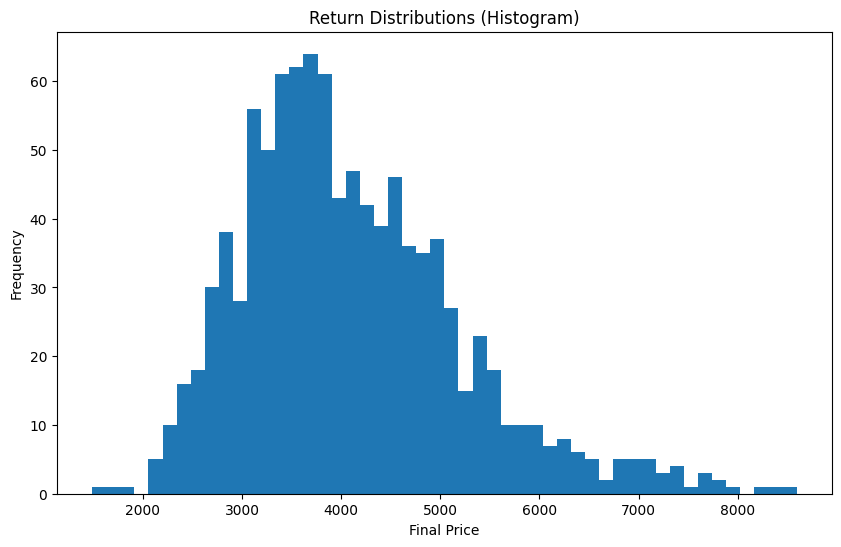

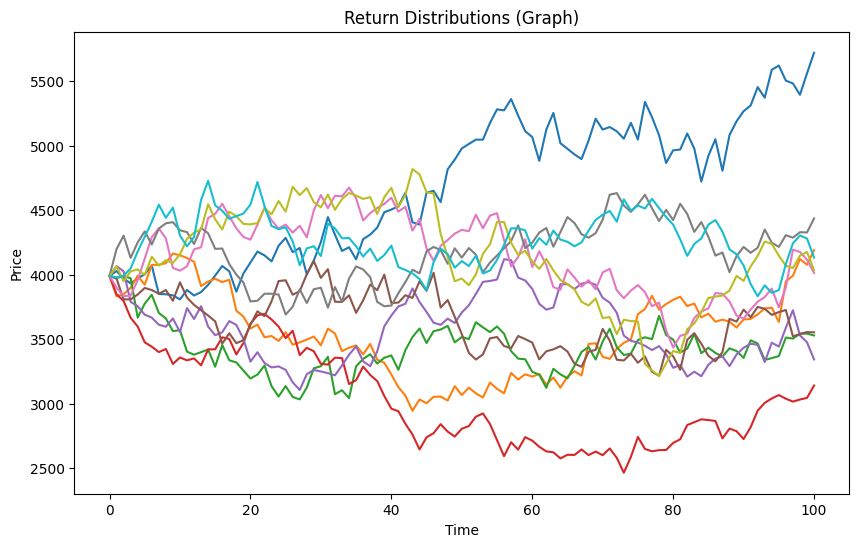

In [61]:
plot_gbm(S0, mu, sigma, T, M, show_hist = True)

More realistically, we might not necessarily know what S(0), μ, and σ are, or we might want to compute them given existing data. We can access existing data using the "pandas-datareader" module.

In [62]:
#you might have to run the following commands to install these libraries:
!pip install yfinance
!pip install pandas-datareader

#Import required libraries to perform our analysis
import math
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yfin
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt

yfin.pdr_override()

You can model data for any stock index by replacing the ticker symbol "SPY" with your stock index of choice. Additionally, you can also adjust the time frame of observation. Here, we're  choosing to look just at the adjusted close. Remember that the adjusted close is the closing price of a stock after all dividends and stock splits are factored into the price.

In [63]:
data = pd.DataFrame()
data = pdr.get_data_yahoo("SPY", start="2010-1-1", end="2022-1-25")['Adj Close']

data

[*********************100%***********************]  1 of 1 completed


Date
2010-01-04     87.791763
2010-01-05     88.024185
2010-01-06     88.086166
2010-01-07     88.458000
2010-01-08     88.752380
                 ...    
2022-01-18    445.838440
2022-01-19    441.209076
2022-01-20    436.325714
2022-01-21    427.760345
2022-01-24    429.576965
Name: Adj Close, Length: 3036, dtype: float64

Let's also go ahead and plot the adjusted closing values as a function of time. This definitely looks like some sort of stochastic process! Does this graph remind you of anything?

<Axes: xlabel='Date'>

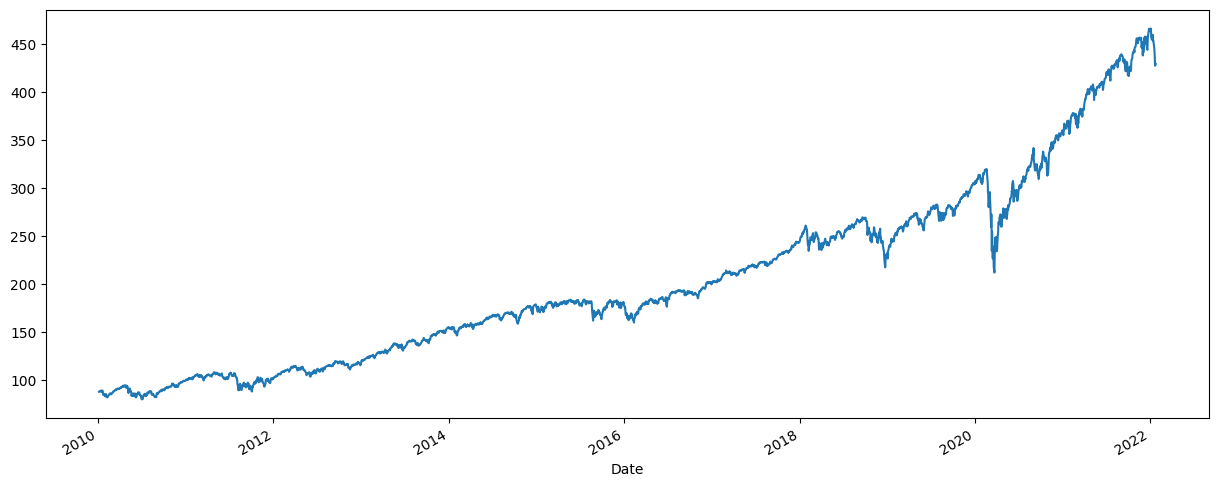

In [64]:
data.plot(figsize = (15, 6))

Given this data, let's start to analyze it. One thing we can do is compute the logarithms of the returns of each day:

In [65]:
log_returns = np.log(1+data.pct_change())
log_returns

Date
2010-01-04         NaN
2010-01-05    0.002644
2010-01-06    0.000704
2010-01-07    0.004212
2010-01-08    0.003322
                ...   
2022-01-18   -0.017868
2022-01-19   -0.010438
2022-01-20   -0.011130
2022-01-21   -0.019826
2022-01-24    0.004238
Name: Adj Close, Length: 3036, dtype: float64

Let's also go ahead and plot these as a histogram. As expected, the log of the returns seems to be normally distributed.

Text(5.069444444444445, 0.5, 'Frequency')

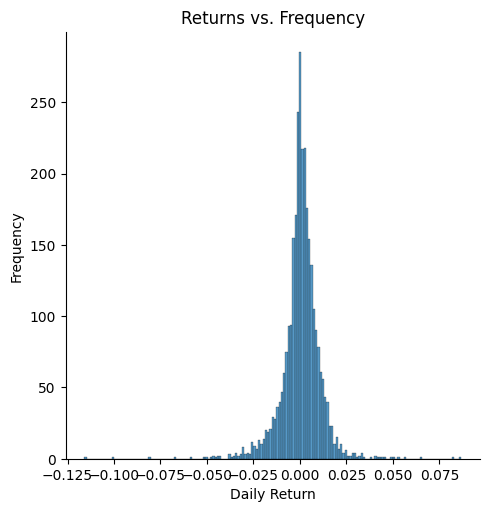

In [66]:
sns.displot(log_returns.iloc[1:])
plt.title("Returns vs. Frequency")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")

Given the log returns, we can compute their mean, variance, drift, and standard deviation. We can also obtain and derive the initial value or price of the index, so that we can plug this information all into the Modified Geometric Brownian Motion model.

In [67]:
mu = log_returns.mean()
var = log_returns.var()
drift = mu - (0.5*var)
stddev = log_returns.std()
S0 = data.iloc[-1]
time = 10/52 #time period (10 weeks out of 52 weeks or 1 year)

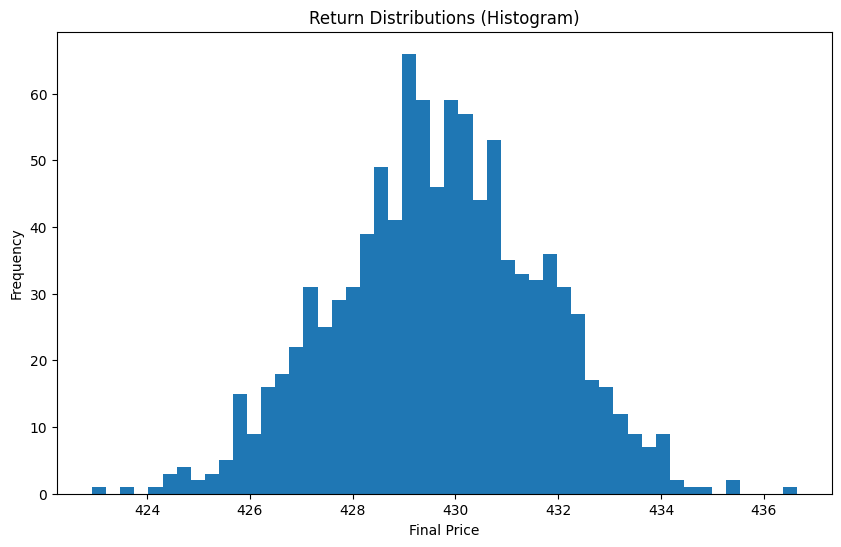

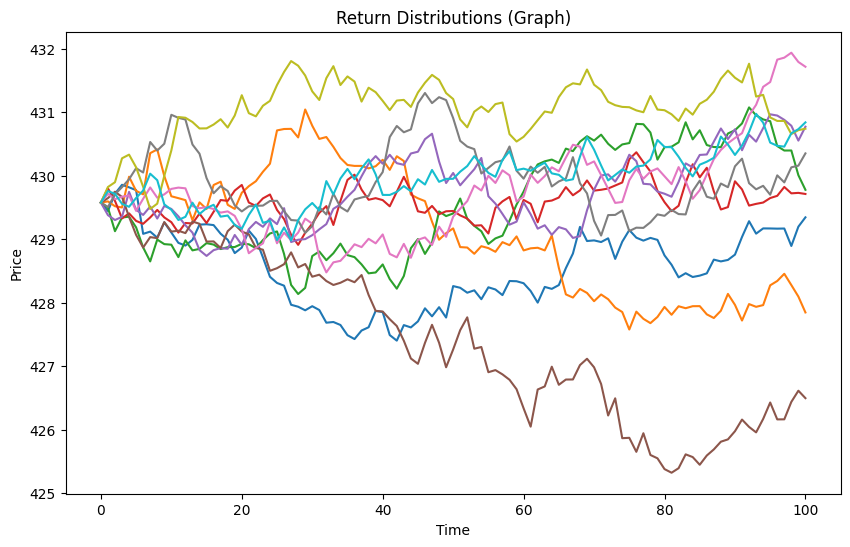

In [68]:
plot_gbm(S0, mu, stddev, time, 100)

We can also just do this directly:

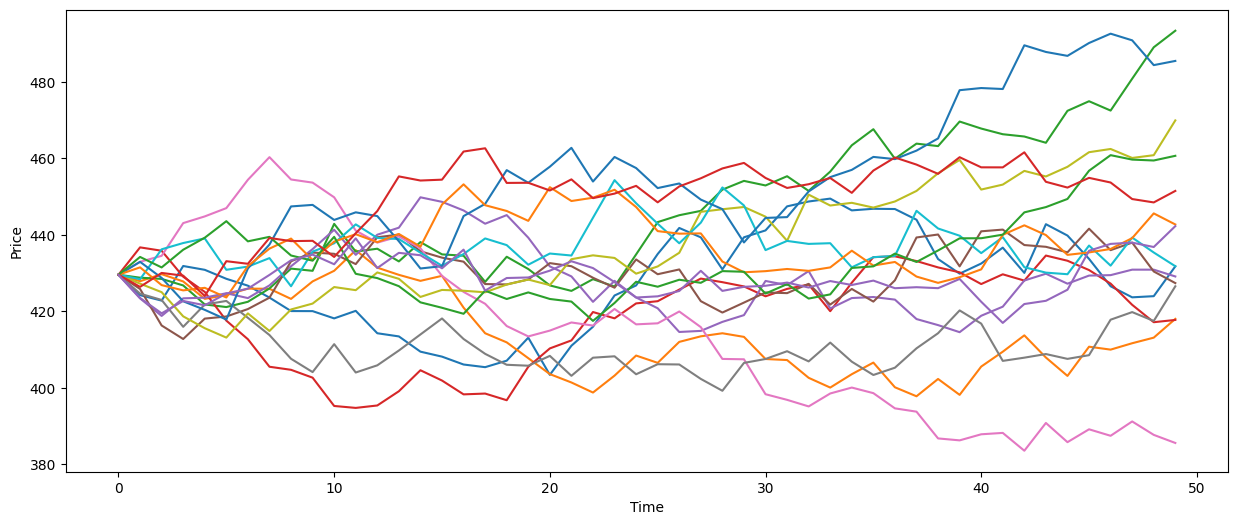

In [69]:
x = np.random.rand(10, 2)
norm.ppf(x)
Z = norm.ppf(np.random.rand(50, 1000))
t_intervals = 1000
iterations = 10
daily_returns = np.exp(drift + stddev * norm.ppf(np.random.rand(50, 1000)))

price_list = np.zeros_like(daily_returns)
price_list[0] = S0
for t in range(1,50):
    price_list[t] = price_list[t-1]*daily_returns[t]

plt.figure(figsize=(15,6))
plt.xlabel("Time")
plt.ylabel("Price")
plt.plot(pd.DataFrame(price_list).iloc[:,0:15])

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,429.576965,429.576965,429.576965,429.576965,429.576965,429.576965,429.576965,429.576965,429.576965,429.576965,...,429.576965,429.576965,429.576965,429.576965,429.576965,429.576965,429.576965,429.576965,429.576965,429.576965
1,424.244566,427.882867,428.805462,436.737499,423.392630,425.858408,432.958629,424.629187,427.248002,428.408626,...,431.417170,426.480628,432.236490,438.954839,425.388133,428.235069,431.204181,431.797280,434.702689,435.483500
2,422.810682,429.727926,428.489621,435.857309,418.808346,416.302820,434.523976,422.983193,425.020996,436.231298,...,433.291164,428.885928,429.690486,432.277795,427.996051,430.637671,421.441720,428.569229,426.962675,443.559783
3,431.864109,427.823397,426.778293,429.067647,423.403029,412.768514,443.088110,415.954684,418.690923,437.872458,...,434.494362,431.372207,433.932793,444.031930,428.346651,425.675357,428.896769,419.086341,432.083765,444.258210
4,430.865728,423.268949,421.809785,425.081003,423.583637,418.103423,444.838284,421.784808,415.588467,439.087969,...,429.720549,437.028413,435.221597,442.123085,433.088339,427.081156,429.472099,423.935942,431.291290,448.886797


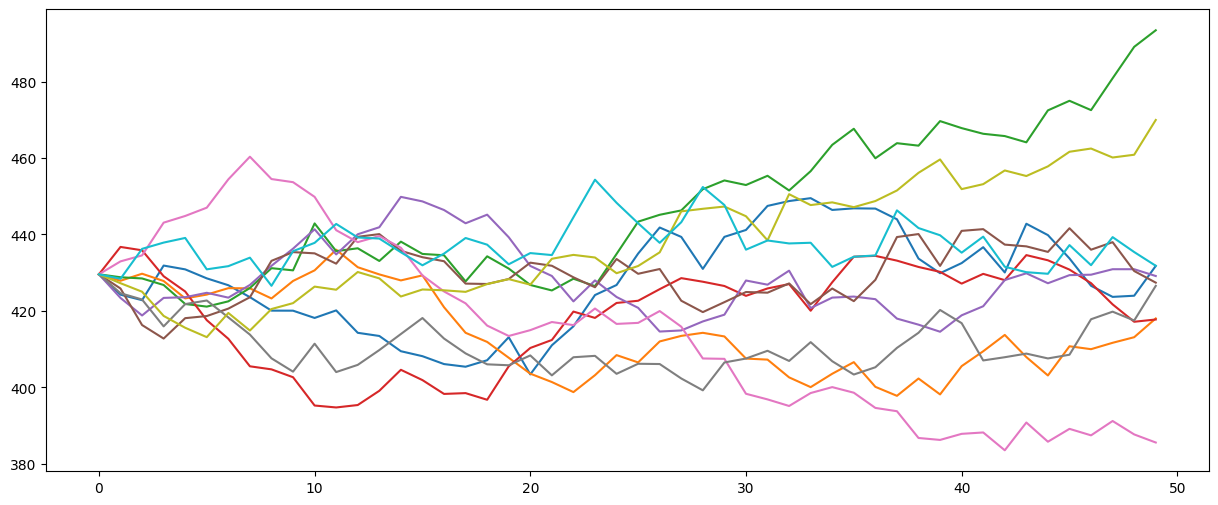

In [70]:
plt.figure(figsize=(15,6))
plt.plot(pd.DataFrame(price_list).iloc[:,0:10])
df = pd.DataFrame(price_list)
df.head()

Finally, we can put the ending values into a DataFrame and plot those values as a histogram.

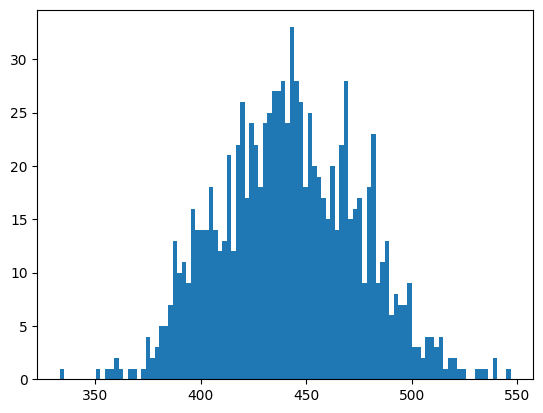

In [71]:
values = []

[values.append(df[column][49]) for column in df.columns]

plt.hist(values, bins = 100)
plt.show()

**References:**

1. G. Dhesi, M. Bilal Shakeel, L. Xiao. "Modified Brownian Motion Approach to Modelling Returns Distribution". 2015, https://arxiv.org/pdf/1507.02203.pdf.